### Implementations précédentes

In [66]:
import torch
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt

class NewtonMethod(object):  
    '''
        Newton Method
        
        Attributes:
            f: fonction à optimiser
    '''    

    def __init__(self):  
        self.f = None


    def define_function(self,f,gradf,Hf):
        """
        Définition de la fonction à optimiser
        """
        self.f = f
        self.gradf = gradf
        self.Hf = Hf

    def compute_stepsize(self,previous_alpha):
        """
        Fonction de calcul du taux d'apprentissage
        """
        return 1

  

    def compute_gradient_hessian(self,w):
        """
        Calcul du gradient et la matrice hessienne
        """
        return self.gradf(w), self.Hf(w)

    
    def update_w(self,w,grad,H,alpha):
        """
        Mise à jour des poids w
        """
        return w - alpha*torch.matmul(H.inverse().T,grad)


class GlobalConvergentNewton(NewtonMethod):
      def compute_direction(self,w,grad,H):
        #Calcul de la direction 
        n = H.shape[0]
        e = torch.linalg.eigvals(H)
        lambda_min = min(e.real)
        lambda_ = max(-lambda_min.numpy(),0)
        new_H = H + lambda_*torch.eye(n)     
        direction = -new_H.inverse().T @ grad
        return direction
    

      def linesearch(self,w,d,c,theta):
        #Calcul du taux d'apprentissage avec une recherche linéaire
        grad, H = self.compute_gradient_hessian(w) 
        fx = self.f(w)
        alpha = 1
        while self.f(w+alpha*d) > fx + c*alpha*d.T @ grad: 
          alpha *= theta      
        return alpha
      
      def run(self,w0,epsilon=1e-4, nb_iterations = 50,convergence = "epsilon",c=0.0001,theta=0.5):
        """
        Lancement de l'algorithme
        convergence : choix du mode de convergence (espilon ou iterations)
        epsilon : critère de convergence
        nb_iterations : nombre d'itérations de l'algorithme       
        theta : valeur initiale pour la recherche linéaire de Armijo
        c : paramètre de la recherche linéaire
        """
        k = 0
        w = w0

        w_values = []
        f_values = []
        while True:        
            k += 1
            if k % 10 == 0:
              print(k)

            #compute gradient and hessian matrix at w
            grad, H = self.compute_gradient_hessian(w)

            #compute direction
            d = self.compute_direction(w,grad,H)

            #linesearch and update of w
            alpha = self.linesearch(w,d,c,theta)    

            w = w + alpha*d

            w_values.append(w.detach().numpy())
            f_values.append(self.f(w).detach().numpy()[0])

            #convergence 
            if convergence == "epsilon":
              if torch.linalg.norm(grad) < epsilon:
                print(f"Convergence en {k} iterations")
                break
            else:
              if k > nb_iterations:
                print(f"Arrêt à {k} iterations")
                break

        return w_values,f_values


class BGFS_Newton(NewtonMethod):
      def compute_direction(self,grad,Hk): 
        return -Hk @ grad


      def linesearch(self,w,d,c,theta):
          #Calcul du taux d'apprentissage avec une recherche linéaire
          grad, _ = self.compute_gradient_hessian(w)   
          fx = self.f(w)
          alpha = 1        
          while self.f(w+alpha*d)  >  fx + c*alpha * d.T @ grad: 
            alpha *= theta      
          return alpha


      def run(self,w0,epsilon=1e-3, nb_iterations = 50,
              convergence = "epsilon",c = 0.0001, theta = 0.5,verbose=True):
        k = 0
        w = w0

        w_values = []
        f_values = []

        m = len(w0)
        Hk = torch.eye(m,dtype=torch.float64) 
        while True:        
            k += 1

            #compute gradient and hessian matrix at w
            grad, H = self.compute_gradient_hessian(w)

            #compute direction
            d = self.compute_direction(grad,Hk)
            
             #initial value of theta
            alpha = self.linesearch(w,d,c,theta)   

            #update
            w_old = w
            w = w + alpha*d

            #compute Hk
            new_grad, H = self.compute_gradient_hessian(w)
            sk = w - w_old
            vk = new_grad - grad

            vk = vk.resize(m,1)
            sk = sk.resize(m,1)

            if sk.T @ vk > 0:
                M = (vk @ sk.T) / (sk.T @ vk)
                N = (sk @ sk.T) / (sk.T @ vk)
                A = torch.eye(m,dtype=torch.float64) - M
                Hk = A.T @ Hk @ A + N

            w_values.append(w.detach().numpy())
            f_values.append(self.f(w).detach().numpy()[0])

            #convergence 
            if convergence == "epsilon":
              if torch.linalg.norm(grad) < epsilon:
                if verbose:
                  print(f"Convergence en {k} iterations")
                break
            else:
              if k > nb_iterations:
                if verbose:
                  print(f"Arrêt à {k} iterations")
                break

        return w_values,f_values

class L_BGFS_Newton(BGFS_Newton):

      def L_BFGS_update(self,memory_size,pairs,m):  
        if len(pairs) >= memory_size:
            l = max(0,memory_size-1)
        else:
            l = 0
        Hk = torch.eye(m,dtype=torch.float64)  

        for i in range(0,l):
          sk,vk = pairs[i]

          vk = vk.reshape(m,1)
          sk = sk.reshape(m,1)

          if sk.T @ vk > 0:
            M = (vk @ sk.T)/ (sk.T @ vk)
            N = (sk @ sk.T)/ (sk.T @ vk)
            A = torch.eye(m,dtype=torch.float64) - M
            Hk = A.T @ Hk @ A + N
        return Hk
      

      def run(self,w0,epsilon=1e-4, memory_size = 5,nb_iterations = 50,
                convergence="epsilon",
                c = 0.0001,
                theta = 0.5):
        k = 0
        w = w0
        w_values = []
        f_values = []
        pairs = []

        m = len(w0)
        Hk = torch.eye(m,dtype=torch.float64) 
        while True:        
            k += 1

            #compute gradient and hessian matrix at w
            grad, H = self.compute_gradient_hessian(w)

            #compute direction
            d = self.compute_direction(grad,Hk)

            #linesearch and update of w            
            alpha = self.linesearch(w,d,c,theta)    

            #update
            w_old = w
            w = w + alpha*d

            #compute Hk
            new_grad, H = self.compute_gradient_hessian(w)
            sk = w - w_old
            vk = new_grad - grad

            pairs.append((sk,vk))

            if len(pairs) > memory_size:
              pairs.pop(0)

            Hk = self.L_BFGS_update(memory_size,pairs,m)

            w_values.append(w.detach().numpy())
            f_values.append(self.f(w).detach().numpy()[0])

            if convergence == "epsilon":
              if torch.linalg.norm(grad) < epsilon:
                print(f"Convergence en {k} iterations")
                break
            else:
              if k > nb_iterations:
                print(f"Arrêt à {k} iterations")
                break

        return w_values,f_values



## Data Generation

In [2]:
# Preamble: useful toolboxes, librairies, functions, etc.
%matplotlib inline
import matplotlib.pyplot as plt

from numba import njit, jit, jitclass  # A just in time compiler to accelerate the calculation

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.

def simu_linmodel(w, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

# Generate the problem instances - we use moderate sizes but those will serve our purpose
d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(0)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

Xlin, ylin = simu_linmodel(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_linmodel(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Taking the logarithm for binary classification

/tmp/ipykernel_25434/1105325260.py:14: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz # A special kind of matrices


## Subsampling Newton methods

***Implementation 2.1 Implement a subsampling Newton method with the following requirements:***
- The method should take $|S_k|$ and $|S_k^H|$ as inputs (for simplicity, we only consider constant
sample sizes).
- The method should be able to use two different stepsize approaches:
  - Constant stepsize α k = α > 0 (provided by the user);
  - Stepsize computed via the subsampling line-search technique described in Definition 2.1.

In [3]:
import torch 
from torch.autograd.functional import hessian
from random import sample
from tqdm import tqdm


class SubsamplingNewton():
  """
  In subsampling Newton methods, we construct stochastic gradient and Hessian estimates from
  batches of data points, akin to a batch stochastic gradient approach.

  Inputs :
    X : Numerical features
    y : Target
    fi : Objective function at (xi,yi,w)
    gradf : Gradient of the objective wrt to w at (xi,yi,w)
    Hf : Hessian matrix at (xi,yi,w)
    step : choice of stepsize ["constant", "linesearch"]
  """
  def __init__(self,X,y,fi,gradf,Hf,step):
    self.fi = fi
    self.X = torch.tensor(X,dtype=torch.float64)
    self.y = torch.tensor(y,dtype=torch.float64) 
    self.gradf = gradf
    self.Hf = Hf
    self.n = X.shape[0]
    self.m = X.shape[1]
    self.step = step
    assert(X.shape[0] == len(y))

  def get_Xrow(self,idx):
    return self.X[idx,:].reshape(self.m,1)

  def compute_gradient(self,w,Sk):  
    grad = torch.zeros_like(w,dtype=torch.float64)

    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      grad += self.gradf(xi,yi,w)
    grad /= len(Sk)
    return grad


  def compute_hessian(self,w,Sk):
    H = torch.zeros(self.m,self.m, dtype=torch.float64)

    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      H += self.Hf(xi,yi,w)
    H /= len(Sk) 
    return H

  def compute_direction(self,w,Sk,SkH):
    grad = self.compute_gradient(w,Sk)

    H = self.compute_hessian(w,SkH)  
    return  -torch.inverse(H) @ grad ,grad,H
    

  def linesearch(self,w,d,c,theta,grad,Sk):
        #Calcul du taux d'apprentissage avec une recherche linéaire
        fx = self.f_sk(w,Sk)
        alpha = 1        
        while self.f_sk(w+alpha*d,Sk) >  fx + c*alpha * d.T @ grad: 
          alpha *= theta      

        return alpha

  def f(self,w):
    y = 0
    for i in range(self.n):
      xi = self.get_Xrow(i)
      yi = self.y[i]
      y += self.fi(xi,yi,w)
    y /= self.n
    return y


  def f_sk(self,w,Sk):
    y = 0
    for i in Sk:
      xi = self.get_Xrow(i)
      yi = self.y[i]
      y += self.fi(xi,yi,w)

    y /= len(Sk)
    return y

  def run(self,w0,epsilon=1e-4, size_Sk=1,size_SkH=1,alpha0 = 0.01,
          nb_iterations = 50,convergence = "epsilon",
          c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []

      while True:        
        k += 1


        Sk = sample(list(range(self.n)),size_Sk)
        SkH = sample(list(range(self.n)),size_SkH)
        d,grad,_ = self.compute_direction(w,Sk,SkH)


        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        elif self.step == "Sk":
          m = len(w)
          X_temp = torch.zeros(m,m)

          for i in Sk:
            xi = self.get_Xrow(i)
            X_temp +=  xi @ xi.T
          
          Lsk = 4*torch.norm(X_temp)/size_Sk + 0.0001
          alpha = alpha0/Lsk
        else:
          alpha = alpha0

        w = w + alpha*d
        # print(self.f(w).detach().numpy())
        w_values.append(w.detach().numpy())
        f_values.append(self.f(w).detach().numpy()[0])

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values

Question 2.1 Using the same (synthetic) dataset than in lab 3 of the course (on stochastic gradient
methods), compare the subsampling Newton method with the standard Newton method with the
following settings:
- Use the appropriate version of Armijo line search for each method (use the same c and θ);
- Use different sizes for |S k | and |S k H |, including the configuration |S k | = |S k H | = 1.

Subsampling : 1 itération = $|S_k| + |S_{kH}|$ accès aux données = $\frac{|S_k| + |S_{kH}|}{n}$ epoch 

Standard Newton : 1 itération = $n$ accès aux données = 1 epoch 

### Subsampling Newton

In [45]:
def fi(xi,yi,w):
    return np.log(1 + torch.exp(-yi*xi.t() @ w)) + 0.0001/2*torch.linalg.norm(w)**2

def gradf_i(xi,yi,w):
    return -yi/(1+np.exp(yi*xi.T @ w))*xi + 0.0001*w

def Hf_i(xi, yi, w):
    H = xi @ xi.T
    H *= np.exp(yi*w.T@xi)/(1+np.exp(yi*w.T@xi))**2
    H += 0.0001*np.eye(len(w))
    return H

SGSO = SubsamplingNewton(Xlog,ylog,fi,gradf_i,Hf_i,step = "linesearch")

torch.manual_seed(42)
#initialisation aléatoire pour les poids w0
w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_values, f_values = SGSO.run(w0,
                              size_Sk=128,
                              size_SkH=128,
                              nb_iterations = 100,
                              convergence="nb_iterations",
                              c=0.0001,theta=0.2)

Arrêt à 101 iterations


In [46]:
print("f(w) =",f_values[-1])

f(w) = [0.54196141]


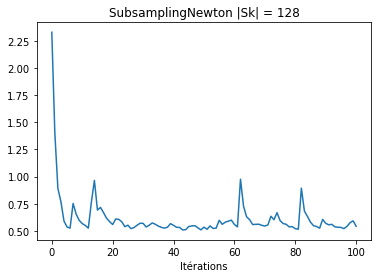

In [47]:
plt.title("SubsamplingNewton |Sk| = 128")
plt.xlabel("Itérations")
plt.xlabel("Itérations")
plt.plot(f_values)

Standard Newton (with line search)

In [7]:
newton = GlobalConvergentNewton()
Xlog_ = torch.tensor(Xlog,dtype=torch.float64)
ylog_ = torch.tensor(ylog,dtype=torch.float64)

In [48]:
def fi(xi,yi,w):
    return torch.log(1 + torch.exp(-yi*xi.T @ w)) + 0.0001/2*torch.linalg.norm(w)**2


def get_X_row(idx):
  return Xlog_[idx,:].reshape(Xlog_.shape[1],1)

def f(w):
  temp = 0
  n = Xlog_.shape[0]
  for i in range(n):
    xi = get_X_row(i)
    yi = ylog_[i]
    temp += fi(xi,yi,w)
  temp /= n
  return temp

def gradf(w):
  grad = torch.zeros_like(w,dtype=torch.float64)
  n = Xlog_.shape[0]
  for i in range(n):
    xi = get_X_row(i)
    yi = ylog_[i]
    temp = -yi/(1+torch.exp(yi*xi.T @ w))*xi + 0.0001*w
    grad += temp
  grad /= n
  return grad

def Hf(w):
  n = Xlog_.shape[0]
  m = len(w)
  H = torch.zeros(m,m, dtype=torch.float64)
  for i in range(n):
    xi = get_X_row(i)
    yi = ylog_[i]
    temp = xi @ xi.T
    temp *= torch.exp(yi*w.T@xi)/(1+torch.exp(yi*w.T@xi))**2
    temp += 0.0001*torch.eye(m)
    H += temp
  H /= n
  return H

newton.define_function(f,gradf,Hf)
w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_values2, f_values2 = newton.run(w0,convergence="epsilon",
                                  nb_iterations = 29,c=0.0001,theta=0.5)

Convergence en 8 iterations


In [49]:
print("w = ",w_values2[-1])
print("f(w) =",f_values2[-1])

w =  [[ 1.82391915]
 [-1.87503657]
 [ 1.55238048]
 [-1.37658263]
 [ 1.49185614]
 [-1.1472574 ]
 [ 1.06145494]
 [-0.9112604 ]
 [ 0.73345025]
 [-0.84016346]
 [ 0.99813258]
 [-0.57759933]
 [ 0.48051589]
 [-0.46665379]
 [ 0.31053821]
 [-0.38013027]
 [ 0.29265285]
 [-0.19959718]
 [ 0.37235441]
 [-0.49097887]
 [ 0.29792984]
 [-0.27542024]
 [ 0.37790202]
 [-0.1631347 ]
 [-0.21441135]
 [ 0.19160599]
 [ 0.13221594]
 [-0.42169534]
 [ 0.22263126]
 [-0.03249719]
 [ 0.12159409]
 [-0.20038403]
 [ 0.01075712]
 [-0.14421451]
 [ 0.12253163]
 [ 0.11082004]
 [ 0.12052775]
 [-0.23178121]
 [ 0.11754429]
 [-0.03420373]
 [ 0.0600533 ]
 [-0.134063  ]
 [ 0.01396096]
 [ 0.03103674]
 [-0.2731635 ]
 [ 0.41526631]
 [ 0.06346513]
 [-0.17653677]
 [ 0.00694596]
 [ 0.15259101]]
f(w) = [0.44980955]


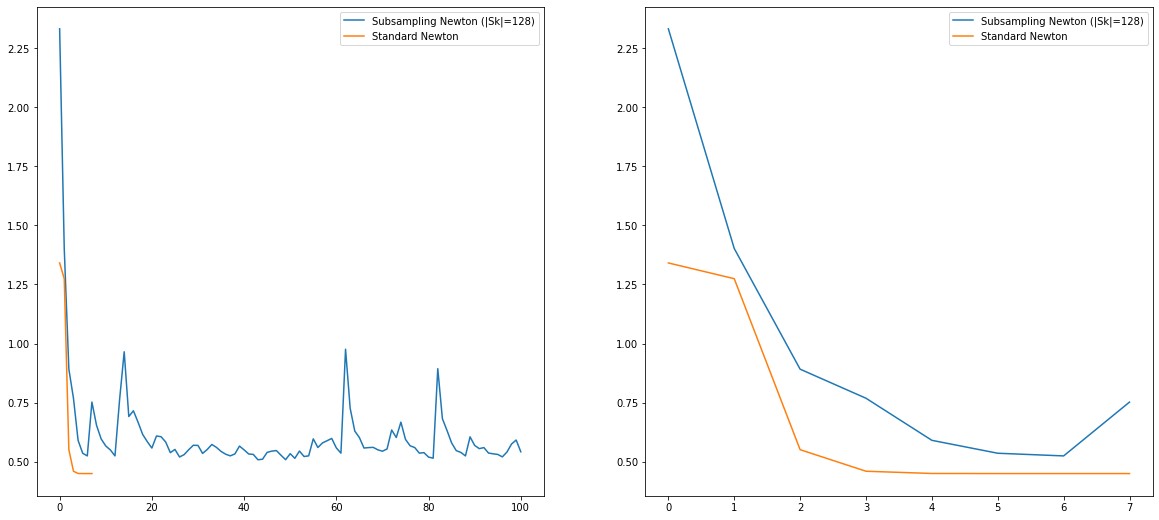

In [50]:
plt.figure(figsize=(20,9))
plt.title("Comparison standard Newton and subsampling Newton")
plt.xlabel("Iterations")
plt.subplot(1,2,1)
plt.plot(f_values)
plt.plot(f_values2)
plt.legend(["Subsampling Newton (|Sk|=128)","Standard Newton"])
plt.subplot(1,2,2)
plt.plot(f_values[:len(f_values2)])
plt.plot(f_values2)
plt.legend(["Subsampling Newton (|Sk|=128)","Standard Newton"])


[0.256, 0.512]
10
Convergence en 10 iterations
Arrêt à 101 iterations
Arrêt à 101 iterations


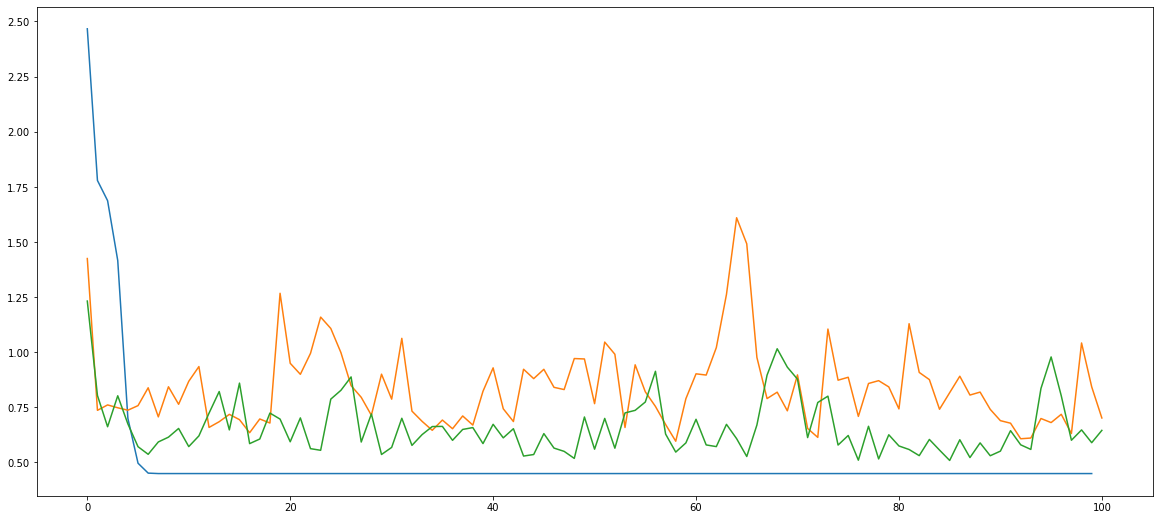

In [87]:
Sk_size_values = [128,256]

N_ITER = 100

n = Xlog_.shape[0]

epochs = list(map(lambda x: 2*x/n ,Sk_size_values))
print(epochs)


plt.figure(figsize=(20,9))

#Globally convergent Newton method
w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_values2, f_valuesStandard_Newton = newton.run(w0,convergence="epsilon",
                                  nb_iterations = 100,c=0.0001,theta=0.5)


temp = []
for i in range(N_ITER):
    if i < len(f_valuesStandard_Newton):
        last_value = f_valuesStandard_Newton[i]
    
    temp.append(last_value)

f_valuesStandard_Newton = temp


plt.plot(f_valuesStandard_Newton)

#remplir les autres valeurs


#Subsampling Newton
for Sk_size in Sk_size_values:  
    w_values, f_values = SGSO.run(w0,
                                size_Sk=Sk_size,
                                size_SkH=Sk_size,
                                nb_iterations = N_ITER,
                                convergence="nb_iterations",
                                c=0.0001,theta=0.5)
    plt.plot(f_values)

                    

Question 2.2 Fix sample sizes for the gradient and Hessian. We consider two possible stepsize
- $\alpha_k = \frac{\bar{α}}{L}$ where $L = \frac{4|XX^T|}{n} + λ$
- $\alpha_k = \frac{\bar{α}}{L_{s_k}}$ where $L_{s_k} = \frac{4|\sum_{i\in S_k}x_i x_i^T|}{|S_k|} +λ$

In [51]:
size_Sk = 32
size_SkH= 32

alpha_bar_values = np.logspace(-1,-3,10)

n = Xlog.shape[0]
lambda_ = 0.0001
L = 4*np.linalg.norm(Xlog @ Xlog.T)/n + lambda_


plt.figure(figsize=(10,5))

N_ITER = 200

res_L = []
res_Lsk = []

SSOM_L = SubsamplingNewton(Xlog,ylog,fi,gradf_i,Hf_i,step = "constant")
SSOM_Lsk = SubsamplingNewton(Xlog,ylog,fi,gradf_i,Hf_i,step = "Sk")

def fi(xi,yi,w):
    xi = xi.reshape(len(xi),1)
    return torch.log(1 + torch.exp(-yi*xi.T@ w)) + 0.0001/2*torch.linalg.norm(w)**2

w0 = torch.rand(Xlog.shape[1], dtype=torch.float64).reshape(Xlog.shape[1],1)

for alpha_bar in alpha_bar_values:
    alpha0 = alpha_bar/L
    print("alpha0 =",alpha0)
    torch.manual_seed(42)
    #initialisation aléatoire pour les poids w0
    w_values, f_values = SSOM_L.run(w0,
                                size_Sk=size_Sk,
                                size_SkH=size_SkH,
                                alpha0 = alpha0,
                                convergence="nb_iterations",
                                nb_iterations=N_ITER,
                                c=0.0001,theta=0.2)

    res_L.append(f_values)   

    w_values, f_values = SSOM_Lsk.run(w0,
                                size_Sk=size_Sk,
                                size_SkH=size_SkH,
                                alpha0 = alpha0,
                                convergence="nb_iterations",
                                nb_iterations=N_ITER,
                                c=0.0001,theta=0.2)

    res_Lsk.append(f_values)   

alpha0 = 0.002048088919421934
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 0.001227797050446188
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 0.0007360449943305401
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 0.00044124738162725315
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 0.00026452085578000943
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 0.00015857608692100363
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 9.506386658634918e-05
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 5.698929079293734e-05
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 3.416418226721217e-05
Arrêt à 201 iterations
Arrêt à 201 iterations
alpha0 = 2.048088919421934e-05
Arrêt à 201 iterations
Arrêt à 201 iterations


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Subsampling Newton with constant $\\alpha_k = \\frac{\\bar{α}}{L}$, $|S_k| = |S_{kH}| = 32$')

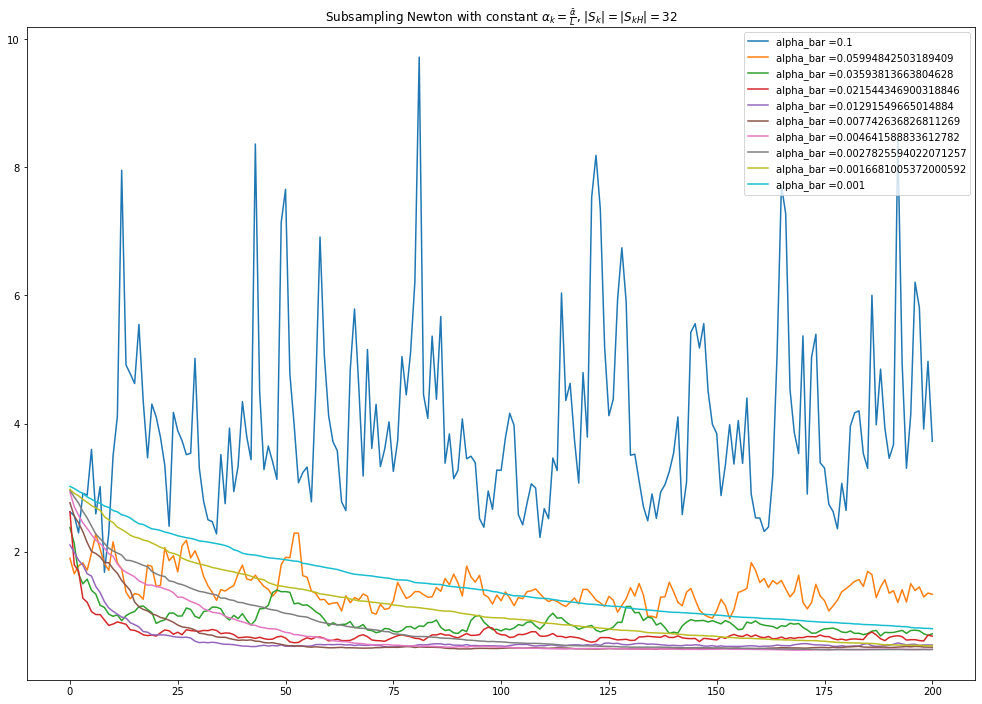

In [90]:
legends = list(map(lambda x:"alpha_bar =" +str(x),alpha_bar_values))

plt.figure(figsize = (17,12))
for f_values in res_L:
    plt.plot(f_values)
plt.legend(legends)
plt.title(r"Subsampling Newton with constant $\alpha_k = \frac{\bar{α}}{L}$, $|S_k| = |S_{kH}| = 32$")

Text(0.5, 1.0, 'Subsampling Newton with $\\alpha_k = \\frac{\\bar{α}}{L_{S_k}}$, $|S_k| = |S_{kH}| = 32$')

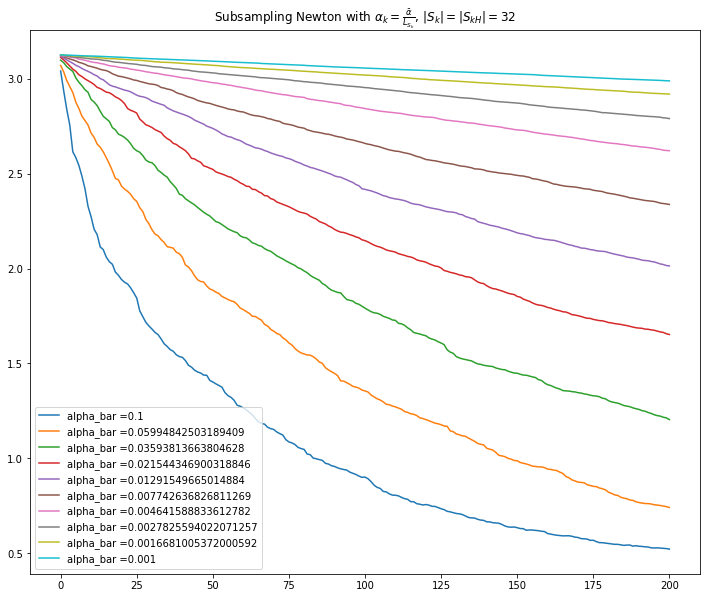

In [35]:
plt.figure(figsize = (12,10))
for f_values in res_Lsk:
    plt.plot(f_values)
plt.legend(legends)
plt.title(r"Subsampling Newton with $\alpha_k = \frac{\bar{α}}{L_{S_k}}$, $|S_k| = |S_{kH}| = 32$")


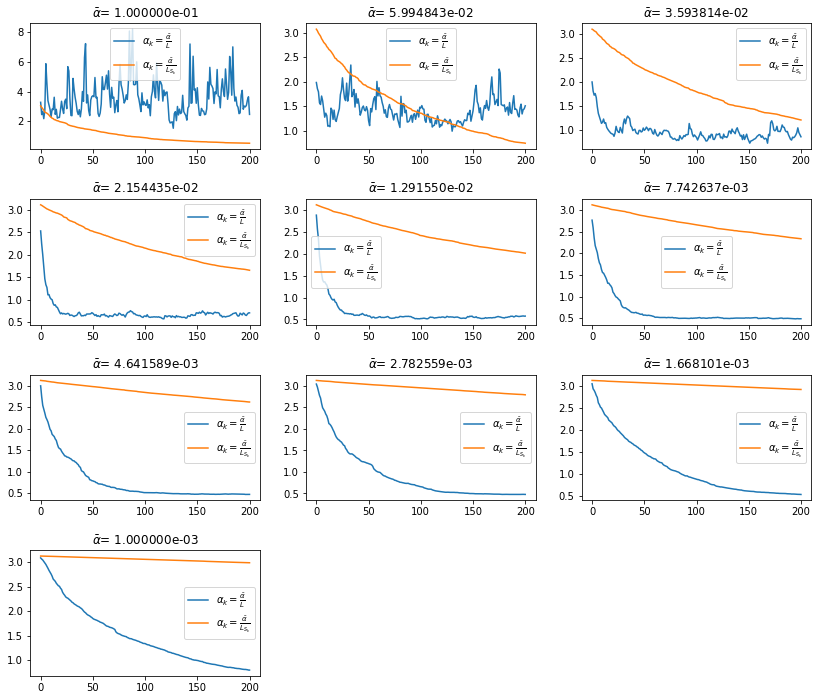

In [36]:
plt.figure(figsize=(14,12))
for i,(alpha_const,alpha_var) in enumerate(zip(res_L,res_Lsk)):
    ax = plt.subplot(4,3,i+1)   
    ax.title.set_text(r"$\bar{α}$= " + "{:e}".format(alpha_bar_values[i]))
    
    plt.plot(alpha_const)
    plt.plot(alpha_var)
    plt.legend([r"$\alpha_k = \frac{\bar{α}}{L}$",r"$\alpha_k = \frac{\bar{α}}{L_{S_k}}$"])
plt.subplots_adjust(hspace=0.4)

## Stochastic quasi-Newton methods

Implementation 2.2 Implement stochastic variants of BFGS and L-BFGS using the modified Armijo
line search described in Definition 2.1, with the following requirements:
- Both methods should take |S k | as an input;
- The same stepsize strategies than in Implementation 2.1 should be included.

In [37]:
class BFGS_StochasticSecondOrderMethod(SubsamplingNewton): 
    """
    Stochastic quasi-Newton methods (BFGS) using the modified Armijo line search
    """
    def compute_direction(self,w,Hk,Sk):
      grad = self.compute_gradient(w,Sk)
      return  -Hk @ grad ,grad


    def run(self,w0,epsilon=1e-4, size_Sk=1,alpha0 = 0.01,nb_iterations = 200,convergence = "epsilon",
                    c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []

      Hk = torch.eye(self.m,dtype=torch.float64) 


      while True:        
        k += 1

        Sk = sample(range(n),size_Sk)
        d,grad = self.compute_direction(w,Hk,Sk)

 #initial value of theta

        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        else:
          alpha = alpha0

        #update
        w_old = w
        w = w + alpha*d

        #compute Hk
        new_grad = self.compute_gradient(w,Sk)
        sk = w - w_old
        vk = new_grad - grad

        vk = vk.reshape(self.m,1)
        sk = sk.reshape(self.m,1)

        if sk.T @ vk > 0:
              M = (vk @ sk.T) / (sk.T @ vk)
              N = (sk @ sk.T) / (sk.T @ vk)
              A = torch.eye(self.m,dtype=torch.float64) - M
              Hk = A.T @ Hk @ A + N


        w_values.append(w.detach().numpy())
        f_values.append(self.f(w).detach().numpy()[0])

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values

In [38]:
SGSO = BFGS_StochasticSecondOrderMethod(Xlog,ylog,fi,gradf_i,Hf_i,step = "constant")

alpha_bar = 0.001
n = Xlog.shape[0]
lambda_ = 0.0001
L = 4*np.linalg.norm(Xlog @ Xlog.T)/n + lambda_
alpha0 = alpha_bar/L

w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_values, f_values = SGSO.run(w0,
                              size_Sk=32,
                              alpha0 = alpha0,
                              convergence="nb_iterations")
print(w_values[-1])
print(f_values[-1])

Arrêt à 201 iterations
[[0.07832844]
 [0.0341384 ]
 [0.12776781]
 [0.03670766]
 [0.50820409]
 [0.42521518]
 [0.90867324]
 [0.87319856]
 [0.08209078]
 [0.10972767]
 [0.15651626]
 [0.3423098 ]
 [0.80155691]
 [0.81094606]
 [0.3425185 ]
 [0.57525096]
 [0.07043358]
 [0.66130955]
 [0.59140628]
 [0.39929016]
 [0.06388158]
 [0.64832134]
 [0.29190982]
 [0.28497575]
 [0.02623402]
 [0.02827439]
 [0.88963644]
 [0.13534002]
 [0.25988457]
 [0.11924748]
 [0.23873301]
 [0.21818742]
 [0.21323074]
 [0.28843402]
 [0.57378219]
 [0.56315322]
 [0.80765553]
 [0.02060905]
 [0.28846783]
 [0.40166448]
 [0.88745347]
 [0.09886631]
 [0.4023144 ]
 [0.26296885]
 [0.93072701]
 [0.7964105 ]
 [0.35623507]
 [0.08767375]
 [0.62507248]
 [0.5521309 ]]
[2.65885973]


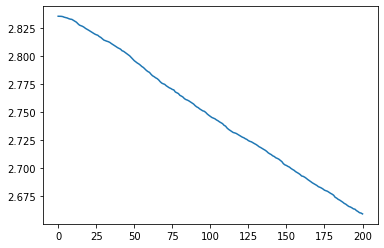

In [39]:
plt.plot(f_values)

In [40]:
class L_BFGS_StochasticSecondOrderMethod(BFGS_StochasticSecondOrderMethod): 
  """
  Stochastic quasi-Newton methods (L_BFGS) using the modified Armijo line search
  """
  def L_BFGS_update(self,memory_size,pairs,m):  
        if len(pairs) >= memory_size:
            l = max(0,memory_size-1)
        else:
            l = 0
        Hk = torch.eye(m,dtype=torch.float64)  

        for i in range(0,l):
          sk,vk = pairs[i]
          if sk.T @ vk > 0:
            M = (vk @ sk.T)/ (sk.T @ vk)
            N = (sk @ sk.T)/ (sk.T @ vk)
            A = torch.eye(m,dtype=torch.float64) - M
            Hk = A.T @ Hk @ A + N
            
                  
        return Hk

  def run(self,w0,epsilon=1e-4, size_Sk=1,memory_size = 5,alpha0 = 0.01,
              nb_iterations = 200,convergence = "epsilon",c = 0.0001, theta = 0.5):
      k = 0
      w = w0
      w_values = []
      f_values = []
      pairs = []

      Hk = torch.eye(len(w0),dtype=torch.float64) 


      while True:        
        k += 1

        Sk = sample(range(self.n),size_Sk)
        d,grad = self.compute_direction(w,Hk,Sk)

 #initial value of theta

        if self.step == "linesearch":
          alpha = self.linesearch(w,d,c,theta,grad,Sk)
        else:
          alpha = alpha0

        #update
        w_old = w
        w = w + alpha*d

        #compute Hk
        new_grad = self.compute_gradient(w,Sk)
        sk = w - w_old
        vk = new_grad - grad

        pairs.append((sk,vk))

        if len(pairs) > memory_size:
          pairs.pop(0)

        Hk = self.L_BFGS_update(memory_size,pairs,self.m)       


        w_values.append(w.detach().numpy())
        f_values.append(self.f(w).detach().numpy()[0])

        if convergence == "epsilon":
          if torch.linalg.norm(grad) < epsilon:
            print(f"Convergence en {k} iterations")
            break
        else:
          if k > nb_iterations:
            print(f"Arrêt à {k} iterations")
            break
      return w_values,f_values

In [41]:
def fi(xi,yi,w):
    return torch.log(1+ torch.exp(-yi*xi.t() @ w)) + 0.001/2*torch.linalg.norm(w)**2

SGSO = L_BFGS_StochasticSecondOrderMethod(Xlog,ylog,fi,gradf_i,Hf_i,step = "constant")


w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_values, f_values = SGSO.run(w0,
                              size_Sk=32,
                              alpha0 = 0.001,
                              convergence="nb_iterations",
                              memory_size = 5)
print(w_values[-1])
print(f_values[-1])

Arrêt à 201 iterations
[[ 0.56592561]
 [-0.12780972]
 [ 0.1630752 ]
 [ 0.06527142]
 [ 0.22882117]
 [ 0.32433763]
 [ 0.08742104]
 [-0.01206527]
 [ 0.40856783]
 [-0.00076123]
 [ 0.01867284]
 [ 0.17155261]
 [ 0.02399336]
 [ 0.23547337]
 [ 0.06623411]
 [ 0.0145505 ]
 [ 0.22867538]
 [ 0.3667276 ]
 [ 0.25046289]
 [-0.1703662 ]
 [ 0.18721991]
 [ 0.39318977]
 [ 0.18832193]
 [-0.16701941]
 [ 0.20824752]
 [-0.10833747]
 [ 0.23775852]
 [ 0.18984343]
 [ 0.00767743]
 [ 0.12715552]
 [ 0.2370616 ]
 [ 0.14898628]
 [ 0.24451319]
 [-0.08976755]
 [ 0.36568482]
 [ 0.46480156]
 [-0.05205558]
 [ 0.22567581]
 [-0.06273709]
 [-0.07429574]
 [ 0.44533745]
 [ 0.32529089]
 [-0.17712738]
 [ 0.1563356 ]
 [ 0.40989838]
 [-0.00620595]
 [ 0.1623975 ]
 [ 0.19862006]
 [-0.14887411]
 [ 0.50344616]]
[1.09246242]


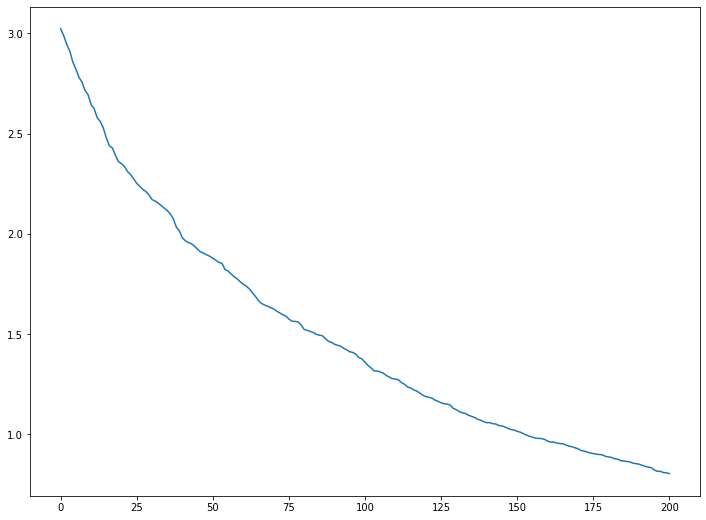

In [93]:
plt.figure(figsize=(12,9))
plt.plot(f_values)

***Question 2.3 Using the same (synthetic) dataset for logistic regression than in Question 2.1, compare the stochastic BFGS and L-BFGS methods with their counterparts from Section 1, using the
appropriate Armijo line-search technique for each method and a fixed epoch budget. Use different
values for the sample size |Sk|, including |Sk| = 1.***

In [67]:
Sk_size_values = [1,2,4,16,32,128,256] 

stoc_BGFS = BFGS_StochasticSecondOrderMethod(Xlog,ylog,fi,gradf_i,Hf_i,step = "constant")
stoc_LBGFS = L_BFGS_StochasticSecondOrderMethod(Xlog,ylog,fi,gradf_i,Hf_i,step = "constant")

memory_size = 5
alpha_bar = 0.01
n = Xlog.shape[0]
lambda_ = 0.0001
L = 4*np.linalg.norm(Xlog @ Xlog.T)/n + lambda_
alpha0 = alpha_bar/L

newtonBGFS = BGFS_Newton()
newtonL_BGFS = L_BGFS_Newton()

newtonBGFS.define_function(f,gradf,Hf)
newtonL_BGFS.define_function(f,gradf,Hf)

N_ITER = 200
w0 = torch.rand(Xlog.shape[1],dtype=torch.float64).reshape(Xlog.shape[1],1)
w_valuesBGFS, f_valuesBGFS = newtonBGFS.run(w0,convergence="nb_iterations",nb_iterations=N_ITER)
w_valuesL_BGFS, f_valuesL_BGFS = newtonL_BGFS.run(w0,memory_size=memory_size,
                                          convergence="nb_iterations",nb_iterations=N_ITER)

f_values_stoc_BGFS_list = []
f_values_stoc_LBGFS_list = []
for Sk_size in Sk_size_values:
    w_values_stoc_BGFS, f_values_stoc_BGFS = stoc_BGFS.run(w0,
                                                            size_Sk=Sk_size,
                                                            alpha0 = alpha0,
                                                            convergence="nb_iterations",
                                                            nb_iterations=N_ITER)
    f_values_stoc_BGFS_list.append(f_values_stoc_BGFS)

    w_values_stoc_LBGFS, f_values_stoc_LBGFS = stoc_LBGFS.run(w0,
                                                    size_Sk=Sk_size,
                                                    alpha0 = alpha0,
                                                    convergence="nb_iterations",
                                                    nb_iterations=N_ITER,
                                                    memory_size = 5)
    f_values_stoc_LBGFS_list.append(f_values_stoc_LBGFS)
    

Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations
Arrêt à 201 iterations


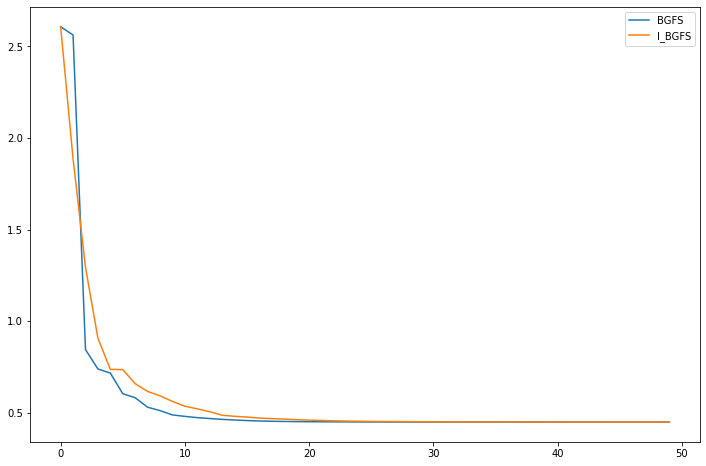

In [68]:
graph_idx = 50

plt.figure(figsize=(12,8))
plt.plot(f_valuesBGFS[:graph_idx])
plt.plot(f_valuesL_BGFS[:graph_idx])
plt.legend(["BGFS","l_BGFS"])

In [69]:
legendsBGFS = list(map(lambda x:"Stoc BGFS |Sk| =" +str(x),Sk_size_values))
legendsLBGFS = list(map(lambda x:"Stoc L_BGFS |Sk| =" +str(x),Sk_size_values))

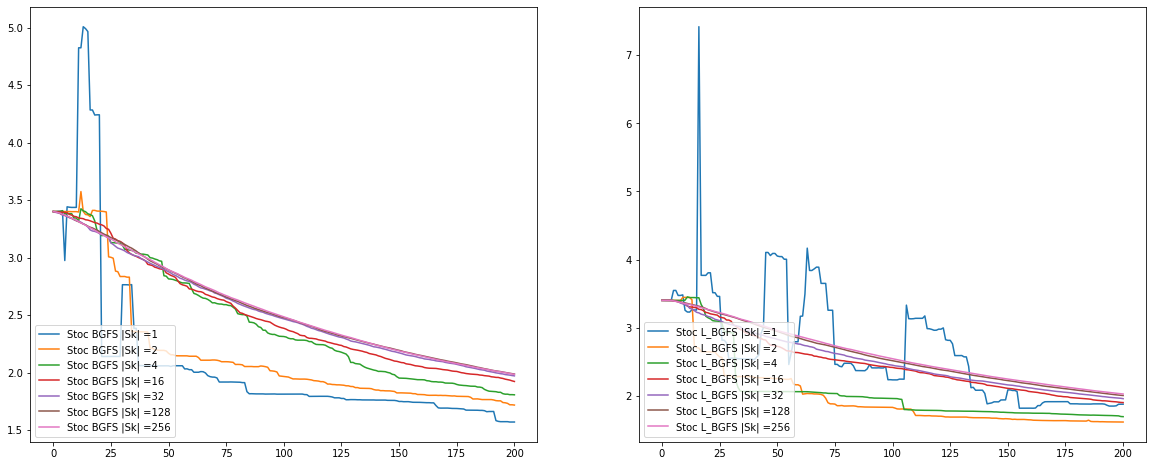

In [70]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
for vals in f_values_stoc_BGFS_list:
    plt.plot(vals)

plt.legend(legendsBGFS,loc="lower left")

plt.subplot(1,2,2)
for vals in f_values_stoc_LBGFS_list:
    plt.plot(vals)

plt.legend(legendsLBGFS,loc="lower left")


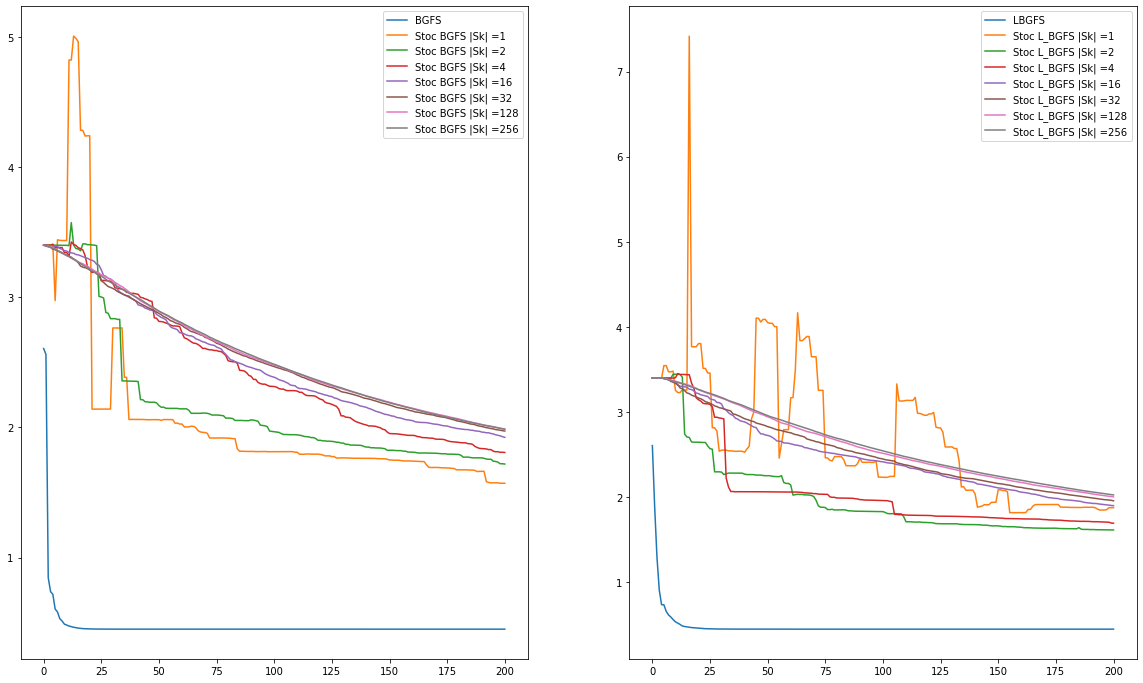

In [71]:
plt.figure(figsize=(20,12))

plt.subplot(1,2,1)
plt.plot(f_valuesBGFS)

for vals in f_values_stoc_BGFS_list:
    plt.plot(vals)

plt.legend(["BGFS"] + legendsBGFS,loc="upper right")

plt.subplot(1,2,2)
plt.plot(f_valuesL_BGFS)

for vals in f_values_stoc_LBGFS_list:
    plt.plot(vals)

plt.legend(["LBGFS"] + legendsLBGFS,loc="upper right")


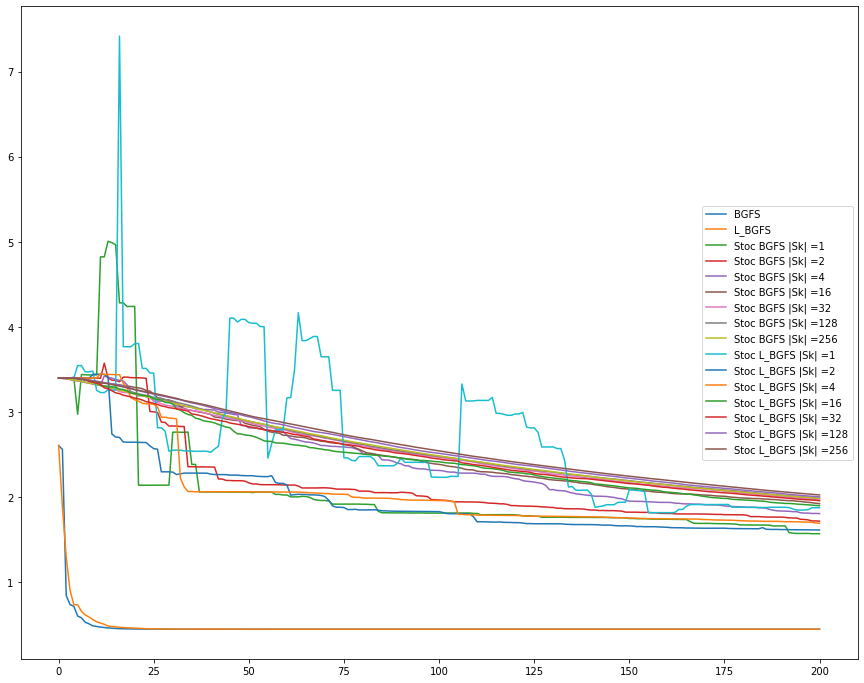

In [72]:
plt.figure(figsize=(15,12))
plt.plot(f_valuesBGFS)
plt.plot(f_valuesL_BGFS)

for vals in f_values_stoc_BGFS_list:
    plt.plot(vals)
for vals in f_values_stoc_LBGFS_list:
    plt.plot(vals)

plt.legend(["BGFS","L_BGFS"] + legendsBGFS + legendsLBGFS,loc="right")

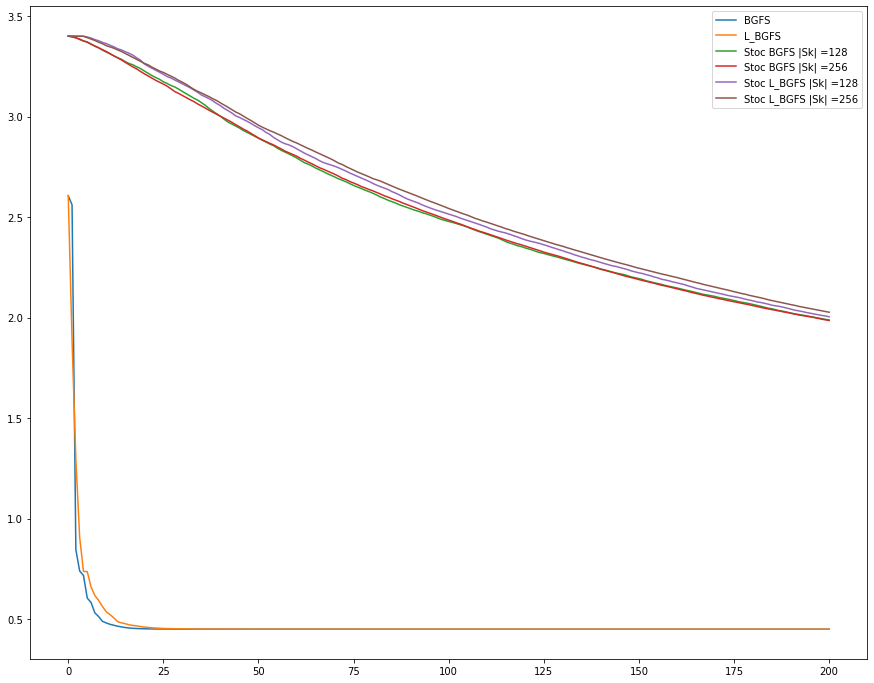

In [73]:
idxs = slice(-2,None)

plt.figure(figsize=(15,12))
plt.plot(f_valuesBGFS)
plt.plot(f_valuesL_BGFS)

for vals in f_values_stoc_BGFS_list[idxs]:
    plt.plot(vals)
for vals in f_values_stoc_LBGFS_list[idxs]:
    plt.plot(vals)

plt.legend(["BGFS","L_BGFS"] + legendsBGFS[idxs] + legendsLBGFS[idxs],loc="upper right")